# Euler with ExaHyPE 2 
 
A very simple example which demonstrates how to configure a patch-based Finite Volume solver in Peano 4 through the ExaHyPE 2 interface/API. The solver simulates the simple Euler equations, i.e. we rely on the abstract first-order hyperbolic expression

$ \partial Q + \nabla ^T \cdot F(Q) = 0$

In this particular case, this formulation is


$ \frac{\partial}{\partial t} \begin{pmatrix}
\rho\\j\\\ E
\end{pmatrix}
+
\nabla\cdot\begin{pmatrix}
{j}\\
\frac{1}{\rho}j\otimes j + p I \\
\frac{1}{\rho}j\,(E + p)
\end{pmatrix}
= 0
 $ 






In [1]:
import os
import peano4
import exahype2

DaStGen 2 (C) www.peano-framework.org
Peano 4 (C) www.peano-framework.org
ExaHyPE 2 (C) www.peano-framework.org


In [2]:
output_files = [ f for f in os.listdir(".") if f.endswith(".peano-patch-file") or f.endswith(".vtu") or f.startswith("output")]
for f in output_files:
  os.remove(f)

The first thing to do in any ExaHyPE 2 application is to create an ExaHyPE project. We have to tell it exactly what namespace we want to use (it is examples::exahype2::euler here), we have to give it a name. There are a few more options that we omit here.

In [3]:
project = exahype2.Project( ["examples", "exahype2", "euler"], "finitevolumes" )

## A Finite Volumes solver

Our first step is to use a Finite Volumes solver. So we add this solver to the project. An ExaHyPE mesh can carry multiple solvers at the same time, but we only use one here.

In [4]:
patch_size     = 11
unknowns       = 5
auxiliary_variables = 0   # This could be something alike material parameters. Not required for Euler.
time_step_size = 0.0001
max_h          = 0.2
min_h          = 0.2
solver = exahype2.solvers.fv.GenericRusanovFixedTimeStepSize(
  "Euler", patch_size, unknowns, auxiliary_variables, min_h, max_h, time_step_size,
  flux=exahype2.solvers.fv.PDETerms.User_Defined_Implementation
)
project.add_solver( solver )

## Configure the global domain

We next configure our global domain, i.e. we specify the dimensions of the computational domain $\Omega $, we specify how long the simulation shall run and how often we want it to dump its data. The dumps will later be used to produce screenshots of the data (or to extract all kinds of properties).

In [5]:
dimensions = 2

if dimensions==2:
  project.set_global_simulation_parameters(
    dimensions,  [0.0,0.0],  [1.0,1.0],
    0.01,        # end time
    0.0, time_step_size*10    # snapshots
  )
else:
  project.set_global_simulation_parameters(
    dimensions, [0.0,0.0,0.0], [1.0,1.0,1.0],
    0.01,                     # end time
    0.0, time_step_size*10     # snapshots
  )


## Generate a Peano 4 project

ExaHyPE's Python API does not really "do" something itself. It is a front-end to create and configure a Peano project. Peano in turn has its own Python API. In principle that allows us to use ExaHyPE 2 as a very high level code generator that we later on tweak. We can even use the outcome to inject further functionality that has never been supported by ExaHyPE 2 yet is available in Peano.

For the time being, none of these things is requires. We therefore simply ask ExaHyPE's API to give us a Peano project. This project is then told to generate the "real" C++ code and to translate. Every system will have a bespoke configuration, i.e. its own set of compilers, include paths, ... All of these ingredients have been chosen and tailored when we issued the configure script. Peano's Python API can parse the outcome of the configure instruction and use the same settings for the ExaHyPE/Peano project, too.

The generation can build up reasonably big data structures. If you work on a low-spec machine, you thus might want to tell the generate command to throw away all generated data after the C++ code has been built up.

In [6]:
build_mode = peano4.output.CompileMode.Asserts
project.set_Peano4_installation("../../..", build_mode)

peano4_project = project.generate_Peano4_project()

parse configure outcome ../../../src/Makefile to extract compile settings
used C++ compiler is g++
used Fortran compiler is gfortran


I first cleanup some local files. Would be a pity to become confused through a lot of output from a previous run.

In [7]:
peano4_project.generate( throw_away_data_after_generation=False )

generate all code ...
some artefacts have already been added to repository ... assume this is intentional (by higher abstraction layer, e.g.)
generated finitevolumes-main.cpp
write ./Makefile
write ././AbstractEuler.h (generated from template /home/anne/Desktop/Projects/exahype/Peano/python/exahype2/solvers/fv/GenericRusanovFixedTimeStepSizeAbstract.template.h)
write ././AbstractEuler.cpp (generated from template /home/anne/Desktop/Projects/exahype/Peano/python/exahype2/solvers/fv/GenericRusanovFixedTimeStepSizeAbstract.template.cpp)
write ./observers/SolverRepository.h (generated from template /home/anne/Desktop/Projects/exahype/Peano/python/exahype2/ProjectSolverRepository.template.h)
write ./observers/SolverRepository.cpp (generated from template /home/anne/Desktop/Projects/exahype/Peano/python/exahype2/ProjectSolverRepository.template.cpp)
write ./celldata/EulerQ.h (generated from template /home/anne/Desktop/Projects/exahype/Peano/python/peano4/datamodel/PatchToDoubleArray.template

## Preparation before you start any ExaHyPE 2 work

Ensure you have configured with the options

./configure --enable-exahype --enable-loadbalancing-toolbox

I do recommend that you use some kind of parallelisation, too, but the two options above are mandatory.


## Preparation before you start the Jupyter notebook

To startup ExaHyPE, we need a couple of imports. To make them work, you will have to set your environment variables correctly before you launch the notebook or Python script respectively. On a standard checkout, this is

export PYTHONPATH=../../../python

or

export JUPYTER_PATH=../../../python

respectively. If you run the notebook locally, you might have to set both pathes. If you prefer to run this example without the browser (might be faster), use the ipython3 command:





In [8]:
!ls

AbstractEuler.cpp  Euler.cpp	       example-scripts	       Makefile
AbstractEuler.h    Euler.h	       facedata		       observers
AbstractEuler.o    Euler.ipynb	       finitevolumes-main.cpp
celldata	   Euler.o	       finitevolumes-main.h
Constants.h	   exahype.log-filter  finitevolumes-main.o


To actually implement our PDE, we have to open Euler.cpp in a text editor of our choice and add in the flux functions. We also add some code snippets to set our initial conditions as well as boundary conditions.

<pre>

void examples::exahype2::euler::Euler::adjustSolution(
  double Q[5],
  const tarch::la::Vector<Dimensions,double>&  x,
  const tarch::la::Vector<Dimensions,double>&  h,
  double                                       t
) {
  if (tarch::la::equals(t,0.0) ) {
    logDebug( "adjustSolution(...)", "init volume at " << x << "x" << h << "x" << t );
    // initial conditions
    bool isInTheCentre = ( tarch::la::norm2( x-tarch::la::Vector<Dimensions,double>(0.5) ) < 0.05 );
    //bool isInTheCentre = x(0)<=0.5;
    //bool isInTheCentre = x(1)<=0.5;
    Q[0] = 0.1;  // rho
    Q[1] = 0;    // velocities
    Q[2] = 0;
    Q[3] = 0;
    Q[4] = isInTheCentre ? 1.0 : 0.0; // inner energy
  }
  else {
    // other stuff
  }
}

void examples::exahype2::euler::Euler::eigenvalues(
  double                                       Q[5],
  const tarch::la::Vector<Dimensions,double>&  faceCentre,
  const tarch::la::Vector<Dimensions,double>&  volumeH,
  double                                       t,
  int                                          normal,
  double                                       lambda[5]
) {
  [...]
}

void examples::exahype2::euler::Euler::flux(
  double                                       Q[5],
  const tarch::la::Vector<Dimensions,double>&  faceCentre,
  const tarch::la::Vector<Dimensions,double>&  volumeH,
  double                                       t,
  int                                          normal,
  double                                       F[5]
) {
  logTraceInWith4Arguments( "flux(...)", faceCentre, volumeH, t, normal );
  [...]
  logTraceOutWith4Arguments( "flux(...)", faceCentre, volumeH, t, normal );
}

void examples::exahype2::euler::Euler::boundaryConditions(
  double                                       Qinside[5],
  double                                       Qoutside[5],
  const tarch::la::Vector<Dimensions,double>&  faceCentre,
  const tarch::la::Vector<Dimensions,double>&  volumeH,
  double                                       t,
  int                                          normal
) {
  logTraceInWith4Arguments( "boundaryConditions(...)", faceCentre, volumeH, t, normal );
  Qoutside[0] = Qinside[0];
  Qoutside[1] = Qinside[1];
  Qoutside[2] = Qinside[2];
  Qoutside[3] = Qinside[3];
  Qoutside[4] = Qinside[4];
  logTraceOut( "boundaryConditions(...)" );
}
</pre>

This particular solver offers several implementation variants. It also can be fed with different memory allocation schemes for any dynamic memory allocation. Not all of them are C++ standard compliant, i.e. Clang for example might refuse to accept them.

In [9]:
# The default
solver.set_update_cell_implementation(
  function_call   = exahype2.solvers.fv.AbstractAoSWithOverlap1.CellUpdateImplementation_NestedLoop,
  memory_location = peano4.toolbox.blockstructured.ReconstructedArrayMemoryLocation.HeapThroughTarch
)

# Something that's way faster on my machine but not C++ compatible (only C99) - Clang might refuse to compile it
#solver.set_update_cell_implementation(
#  function_call   = exahype2.solvers.fv.AbstractAoSWithOverlap1.CellUpdateImplementation_NestedLoop,
#  memory_location = peano4.toolbox.blockstructured.ReconstructedArrayMemoryLocation.CallStack
#)

# A vectorised version with more memory scattering, but usually faster
#solver.set_update_cell_implementation(
#  function_call   = exahype2.solvers.fv.AbstractAoSWithOverlap1.CellUpdateImplementation_SplitLoop,
#  memory_location = peano4.toolbox.blockstructured.ReconstructedArrayMemoryLocation.CallStack
#)

With all project content generated and befilled with semantics, we can finally translate the code. Note that the above steps have actually produced a Makefile in our ExaHyPE 2 project folder. So we can either translate the project through the notebook, or we can switch to a terminal and invoke the translation manually.

Take care with the translation process if you want to use something fancy that is not active by default. If you have particular modules loaded or environment variables set, then all of these are required before you launch the notebook. On my own system, I need for example

<pre>
source /opt/intel/bin/iccvars.sh intel64
source /opt/intel/itac/2020.0.015/bin/itacvars.sh
source /opt/intel/impi/2019.6.166/intel64/bin/mpivars.sh
</pre>

to use the Intel toolchain. I experienced issues with notebooks where compile errors had not been displayed. Have a look at the terminal: It seems that cerr is not always piped into the notebook window. If that doesn't help, the only remaining option is to execute the whole notebook via ipython3.

In [10]:
parallel_builds = 1   # I don't use a massively parallel build here as my laptop otherwise becomes too hot.
                       # Without any arguments, the build process will grab all of your cores.
peano4_project.build( make_clean_first = True, number_of_parallel_builds = parallel_builds )

clean up project ...
clean complete
start to compile with concurrency level of 1 ...
/usr/bin/ld: ../../../src/libTarch_asserts.a(libTarch_asserts_a-Tasks_layered.o): in function `std::thread::thread<tarch::multicore::spawnAndWait(std::vector<tarch::multicore::Task*, std::allocator<tarch::multicore::Task*> > const&)::{lambda()#1}, , void>(tarch::multicore::spawnAndWait(std::vector<tarch::multicore::Task*, std::allocator<tarch::multicore::Task*> > const&)::{lambda()#1}&&)':
/usr/include/c++/9/thread:126: undefined reference to `pthread_create'
collect2: error: ld returned 1 exit status
make: *** [Makefile:40: solver] Error 1

compile not successful


## Run the code and postprocess results

Once we have the Peano 4 project set up and built, we obtain an executable which is standalone. It comprises all the parameters we have set above. So we can either invoke this file on the command line or we can call it through the notebook. Depending on your setup you might want to call the code with a prefix. If you configured Peano with MPI, e.g., you might have to use the mpirun prefix. 

Please note that we pipe the terminal output into a file. This way, we can postprocess the data in the next step.

In [11]:
peano4_project.run( [], prefix = ["mpirun", "-n", "1"], pipefile = "output.txt", rebuild_if_required=False )

run application ...
 61043665620  00:01:01     rank:0       core:0       warning      tarch::logging::Statistics::writeToCSV(string)          no statistics available. Recompile with -DTrackStatistics for runtime sampling (file:tarch/logging/Statistics.cpp,line:142)

run completed without error code, but check for warnings and numerical assertions/errors


True

We first grab and postprocess the data from the output file. This is ExaHyPE 2-specific (though application-generic), so we rely on ExaHyPE's postprocessing routines.



In [12]:
import exahype2.postprocessing

performance_data = exahype2.postprocessing.PerformanceData( "output.txt", verbose=True )

parse output.txt
h_min=0.111111
triggered plot at 0.706100411s
started new time step at 0.8028041189999999s
started new time step at 1.3851783789999998s
started new time step at 1.9705043949999999s
started new time step at 2.54688591s
started new time step at 3.12273068s
started new time step at 3.698835083s
started new time step at 4.275123238s
started new time step at 4.851682841s
started new time step at 5.432720184000001s
started new time step at 6.0097282419999996s
triggered plot at 6.585767591s
started new time step at 6.693703425s
started new time step at 7.293402983s
started new time step at 7.875258802s
started new time step at 8.452386920999999s
started new time step at 9.033566416s
started new time step at 9.636495711s
started new time step at 10.224166952s
started new time step at 10.811670137s
started new time step at 11.401483402s
started new time step at 11.993828336999998s
triggered plot at 12.580574707s
started new time step at 12.680641615s
started new time step at 13

In this worksheet, I'd like to have interactive matplotlib plots: You might need the statement

<pre>
%matplotlib widget
</pre>

but on some of my local notebook servers, this causes a crash. So you have to test this yourself.

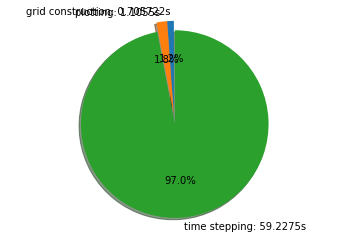

In [13]:
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

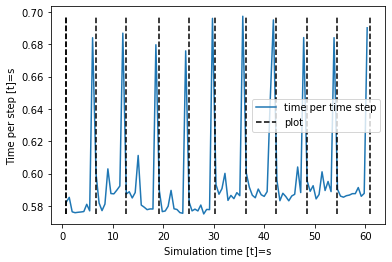

In [14]:
exahype2.postprocessing.plot_time_per_time_step(performance_data)

## Inspecting output files via Paraview

We have different ways how to visualise output. See the guidebook for details. No matter which route we follow, we always first have to find out which files we have, as we need the filenames to trigger the postprocessing/vis. Per solver, we should have a file solution-XXX.peano-patch-file. The XXX is the solver name we have specified above.

In [15]:
!ls

AbstractEuler.cpp	observers
AbstractEuler.h		output.txt
AbstractEuler.o		peano4
celldata		solution-Euler.peano-patch-file
Constants.h		solution-Euler-tree-0-0.peano-patch-file
Euler.cpp		solution-Euler-tree-0-10.peano-patch-file
Euler.h			solution-Euler-tree-0-1.peano-patch-file
Euler.ipynb		solution-Euler-tree-0-2.peano-patch-file
Euler.o			solution-Euler-tree-0-3.peano-patch-file
exahype.log-filter	solution-Euler-tree-0-4.peano-patch-file
example-scripts		solution-Euler-tree-0-5.peano-patch-file
facedata		solution-Euler-tree-0-6.peano-patch-file
finitevolumes-main.cpp	solution-Euler-tree-0-7.peano-patch-file
finitevolumes-main.h	solution-Euler-tree-0-8.peano-patch-file
finitevolumes-main.o	solution-Euler-tree-0-9.peano-patch-file
Makefile


### Explicit conversion

This is an explicit, one-off conversion via an executable invocation. You can trigger this via the command line, i.e. via a manual invocation of the convert script. Alternatively, you can use Peano's Python convert wrapper:

In [16]:
import peano4.visualisation

peano_output_files = "solution-Euler"
convert = peano4.visualisation.Convert( peano_output_files, True )
convert.set_visualisation_tools_path( "../../../src/convert" )
convert.extract_fine_grid()
convert.convert_to_vtk()


ModuleNotFoundError: No module named 'paraview'

Now you can invoke Paraview or VisIt in a separate window and study the outcome. Alternatively, you can use Paraview with its Paraview scripting environment. I select "Tools - Start Trace" and do my postprocessing. Upon hitting "Tools - End Trace" I obtain a Python script to render my stuff that I can insert here. You will have to modify it slightly, but the comments how to do so are all dumped by Paraview.

Alternatively, you can use the ipyparaview plugin as yet find it at https://github.com/Kitware/ipyparaview.git. The description of this one reads really cool, but I haven't managed yet to install it on my machine.

## Embedding the vis into the Jupyter notebook


Paraview has a Jupyter notebook plugin now, and we can use it here to inspect the outcomes of the code directly: The installation process is described at https://gitlab.kitware.com/paraview/paraviewjupyterkernel/-/blob/main/README.md. It sounds great, but I haven't managed to make it run on my machines so far.

## Direct visualisation in Paraview

Once you have converted data into vtk/vtu (see explicit conversion, e.g.), you can load the data dump into Paraview. Alternatively, you can directly display Peano's patch files within paraview. For this, you have to use Paraview's Python plugin. The details are described in the guidebook. The following lines however work for me:

<pre>
import peano4.visualisation
data = peano4.visualisation.render_dataset( \
  "solution-Euler.peano-patch-file", \
  display_as_tree=False, \
  filter=[peano4.visualisation.ExtractFineGridFilter()], \
  dataset_number=0, identifier="EulerQ" \
)
tp = TrivialProducer()
tp.GetClientSideObject().SetOutput(data)
Show(tp)
</pre>

A more sophisticated version loads all the snapshots in one go, but the actual display as movie does not work (yet):

<pre>
import peano4.visualisation
for i in range(0,11):
  data = peano4.visualisation.render_dataset( \
    "solution-Euler.peano-patch-file", \
    display_as_tree=False, \
    filter=[peano4.visualisation.ExtractFineGridFilter()], \
    dataset_number=i, identifier="EulerQ" \
  )
  tp = TrivialProducer()
  tp.GetClientSideObject().SetOutput(data)
  Show(tp)
</pre>

## Working with a symbolic flux function

Without a doubt, it is cumbersome to implement the fluxes et al manually. In ExaHyPE 2, I give users the opportunity to inject code snippets into the solver generation, i.e. instead of asking ExaHyPE and Peano to give you a C++ template that you then befill with content, you can add in content (copy n paste) through the Python interface. This content in turn can stem from SymPy, when we use SymPy's C code generation. This code generation has to stick to some contentions, but ExaHyPE 2 provides an API/SymPy layer for this:

In [17]:
project.remove_all_solvers()  # clean-up
my_solver = exahype2.solvers.fv.GenericRusanovFixedTimeStepSize("SymbolicEuler", patch_size, unknowns, auxiliary_variables, min_h, max_h, 0.0001,
flux=exahype2.solvers.fv.PDETerms.User_Defined_Implementation)
project.add_solver( my_solver )

The above snippet is exactly the same thing we've done before, but this time we keep a reference to the solver. Next, we construct our PDE terms.

In [18]:
import sympy
import exahype2.sympy.FirstOrderConservativePDEFormulation

pde = exahype2.sympy.FirstOrderConservativePDEFormulation(unknowns = 5,auxiliary_variables=0,dimensions = 3)

#
# Give entries in input vector symbolic names. We first declare the constant
# gamma. Then we tell the solver how we would like to name the Q 
# entries
#
gamma = sympy.symbols( "gamma")
rho   = pde.name_Q_entry( 0, "rho" )    # first scalar is rho
j     = pde.name_Q_entries( 1, 3, "j" ) # entries 1-3 (C counting style) holds j vector
E     = pde.name_Q_entry( 4, "E" )      # energy

#
# Define the equation system
#
p = (gamma - 1 ) * (E-1/2 * exahype2.sympy.dot(j,j) / rho)

pde.F[0,:]   = j
pde.F[1:4,:] = 1/rho * exahype2.sympy.outer(j,j) + p * sympy.eye(3)
pde.F[4,:]   = 1/rho * j * (E+p)

c = sympy.sqrt( gamma * p /rho )
pde.eigenvalue[0] = [ j[0]/rho - c, j[1]/rho - c, j[2]/rho - c ]
pde.eigenvalue[1] = [ j[0]/rho, j[1]/rho, j[2]/rho ]
pde.eigenvalue[2] = [ j[0]/rho, j[1]/rho, j[2]/rho ]
pde.eigenvalue[3] = [ j[0]/rho, j[1]/rho, j[2]/rho ]
pde.eigenvalue[4] = [ j[0]/rho + c, j[1]/rho + c, j[2]/rho + c ]

pde.substitute_expression( gamma, 1.4 )


Let's display the outcome in a way we can read it:

In [19]:
from IPython.display import Latex
latex_representation = pde.LaTeX()
latex_representation = latex_representation.replace( "rho", "\\rho" )
Latex( latex_representation )


<IPython.core.display.Latex object>

Now we add these routines to our solver. When Peano creates all user code the next time, it will automatically take the functions phrased via SymPy. You can, obviously, mix, i.e. phrase some things (such as the flux) via SymPy and leave others. You'll then get C++ stubs that you have to implement yourself.

In [20]:
volume_centre = sympy.symbols( "volume_centre")

volume_centre = sympy.sqrt( (0.5-pde.x[0])**2 + (0.5-pde.x[1])**2 )
#volume_centre = sympy.sqrt( (0.5-pde.x[0])**2 + (0.5-pde.x[1])**2 + (0.5-pde.x[2])**2 )

pde.initial_values[0] = 0.1  # rho
pde.initial_values[1] = 0
pde.initial_values[2] = 0
pde.initial_values[3] = 0
pde.initial_values[4] = sympy.Piecewise( (1.0, volume_centre<0.1), (0.0,True) )


In this simple case, we literally everything symbolic, so there's no need for any manual implementation. The only thing we have to do is to tell the PDE that we actually use only two dimensions in this test case. This is kind of a hack - in most real codes you won't first phrase your PDE in 3d and then "downcast" it to 2d. But it does the job here: 

In [21]:
pde.dimensions=2
my_solver.set_implementation(
  flux=pde.implementation_of_flux(),
  eigenvalues=pde.implementation_of_max_eigenvalue(),
  boundary_conditions=pde.implementation_of_homogeneous_Neumann_BC(),
  initial_conditions=pde.implementation_of_initial_conditions(invoke_evalf_before_output=False),
  refinement_criterion=exahype2.solvers.fv.PDETerms.Empty_Implementation
)
my_solver.set_plot_description( pde.unknown_identifier_for_plotter() )

In [22]:
peano4_project = project.generate_Peano4_project()
peano4_project.generate( throw_away_data_after_generation=False )

parse configure outcome ../../../src/Makefile to extract compile settings
used C++ compiler is icpc
used Fortran compiler is ifort
generate all code ...
some artefacts have already been added to repository ... assume this is intentional (by higher abstraction layer, e.g.)
generated finitevolumes-main.cpp
write ./Makefile
write ././AbstractSymbolicEuler.h (generated from template /home/tobias/git/Peano/python/exahype2/solvers/fv/GenericRusanovFixedTimeStepSizeAbstract.template.h)
write ././AbstractSymbolicEuler.cpp (generated from template /home/tobias/git/Peano/python/exahype2/solvers/fv/GenericRusanovFixedTimeStepSizeAbstract.template.cpp)
write ./observers/SolverRepository.h (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.h)
write ./observers/SolverRepository.cpp (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.cpp)
write ./celldata/SymbolicEulerQ.h (generated from template /home/tobias/g

In [23]:
parallel_builds = 8
peano4_project.build( make_clean_first = True, number_of_parallel_builds = parallel_builds )

clean up project ...
clean complete
start to compile with concurrency level of 8 ...
icpc -std=c++0x -g -O2 -DPeanoDebug=2 -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp  -DDimensions=2 -I. -I../../../src -c -o AbstractSymbolicEuler.o AbstractSymbolicEuler.cpp
icpc -std=c++0x -g -O2 -DPeanoDebug=2 -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp  -DDimensions=2 -I. -I../../../src -c -o SymbolicEuler.o SymbolicEuler.cpp
icpc -std=c++0x -g -O2 -DPeanoDebug=2 -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp -I/opt/intel/tbb/include 

We rerun the code to be able to quantify how expensive the symbolic reformulation is.

In [24]:
peano4_project.run( [], prefix = ["mpirun", "-n", "1"], pipefile = "output-symbolic.txt", rebuild_if_required=False )

run application ...
 32208937785  00:00:32     rank:0       core:9       warning      tarch::logging::Statistics::writeToCSV(string)          no statistics available. Recompile with -DTrackStatistics for runtime sampling (file:tarch/logging/Statistics.cpp,line:142)

run completed without error code, but check for warnings and numerical assertions/errors


True

parse output-symbolic.txt
h_min=0.111111
grid construction lasts 1.35749 over 7 steps
plotting lasts 2.82908 over 11 steps
time stepping lasts 28.0041 over 101 steps


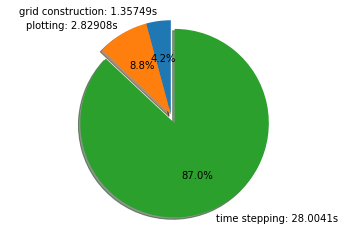

In [25]:
import exahype2

performance_data = exahype2.postprocessing.PerformanceData( "output-symbolic.txt", verbose=False )
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

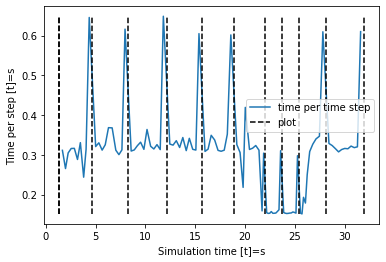

In [26]:
exahype2.postprocessing.plot_time_per_time_step(performance_data)

## Parallelisation

The parallelisation in ExaHyPE 2 is relatively simple. 

- You have to ensure that configure is called with multithreading and/or MPI support. I recommend never to run MPI without multicore parallelisation. Once you have configured it appropriately, please rebuild all libraries.
- You next have to add a load balancing to your Python project. This will then tell your application to exploit all resources. My default load balancing usually a good starting point. 

In [27]:
load_balancing_quality = 0.9  # quantifies computational ill-balance that we are happy accept
#project.set_load_balancing( "toolbox::loadbalancing::RecursiveSubdivision", "(" + str(load_balancing_quality) + ")" )
project.set_load_balancing( "toolbox::loadbalancing::TwoLevelGreedy" )

We now have to rebuild the application and then rerun the code:

In [28]:
peano4_project = project.generate_Peano4_project()
peano4_project.generate( throw_away_data_after_generation=False )


parse configure outcome ../../../src/Makefile to extract compile settings
used C++ compiler is icpc
used Fortran compiler is ifort
generate all code ...
some artefacts have already been added to repository ... assume this is intentional (by higher abstraction layer, e.g.)
generated finitevolumes-main.cpp
write ./Makefile
write ././AbstractSymbolicEuler.h (generated from template /home/tobias/git/Peano/python/exahype2/solvers/fv/GenericRusanovFixedTimeStepSizeAbstract.template.h)
write ././AbstractSymbolicEuler.cpp (generated from template /home/tobias/git/Peano/python/exahype2/solvers/fv/GenericRusanovFixedTimeStepSizeAbstract.template.cpp)
write ./observers/SolverRepository.h (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.h)
write ./observers/SolverRepository.cpp (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.cpp)
write ./celldata/SymbolicEulerQ.h (generated from template /home/tobias/g

In [29]:
parallel_builds = 8
peano4_project.build( make_clean_first = True, number_of_parallel_builds = parallel_builds )

clean up project ...
clean complete
start to compile with concurrency level of 8 ...
icpc -std=c++0x -g -O2 -DPeanoDebug=2 -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp  -DDimensions=2 -I. -I../../../src -c -o AbstractSymbolicEuler.o AbstractSymbolicEuler.cpp
icpc -std=c++0x -g -O2 -DPeanoDebug=2 -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp  -DDimensions=2 

I found that this sometimes does not work (on my Ubuntu system - OpenSUSE was fine). In this case, simply call make and the run on the command line. Ensure you pipe the run's output to output.txt.

In [30]:
!ls

AbstractEuler.cpp
AbstractEuler.h
AbstractEuler.o
AbstractParallelEuler.cpp
AbstractParallelEuler.h
AbstractParallelEuler.o
AbstractSymbolicEuler.cpp
AbstractSymbolicEuler.h
AbstractSymbolicEuler.o
celldata
Constants.h
convert
euler_cpp
Euler.cpp
Euler.h
Euler.ipynb
Euler.o
exahype.log-filter
example-scripts
facedata
finitevolumes-main.cpp
finitevolumes-main.h
finitevolumes-main.o
Makefile
observers
output-symbolic.txt
output.txt
peano4
solution-Euler-0-EulerQ-fine-grid.vtu
solution-Euler-0-EulerQ.vtu
solution-Euler-0.peano-patch-file
solution-Euler-10-EulerQ-fine-grid.vtu
solution-Euler-10-EulerQ.vtu
solution-Euler-10.peano-patch-file
solution-Euler-1-EulerQ-fine-grid.vtu
solution-Euler-1-EulerQ.vtu
solution-Euler-1.peano-patch-file
solution-Euler-2-EulerQ-fine-grid.vtu
solution-Euler-2-EulerQ.vtu
solution-Euler-2.peano-patch-file
solution-Euler-3-EulerQ-fine-grid.vtu
solution-Euler-3-EulerQ.vtu
solution-Euler-3.peano-patch-file
solution-Euler-4-EulerQ-fine-grid.vtu
solution-Euler-4-E

We see that we get a lot of new files. The code does partition the domain now. Each subdomain writes its own snapshot if you trigger a dump. So, overall, the number of output files scales with the number of threads/ranks used.

In [31]:
peano4_project.run( ["--threads","12"], prefix = ["mpirun", "-n", "1"], pipefile = "output-parallel.txt", rebuild_if_required=False )

run application ...
 209918895688 00:03:29     rank:0       core:1       warning      tarch::logging::Statistics::writeToCSV(string)          no statistics available. Recompile with -DTrackStatistics for runtime sampling (file:tarch/logging/Statistics.cpp,line:142)

run completed without error code, but check for warnings and numerical assertions/errors


True

In [32]:
import exahype2.postprocessing

performance_data = exahype2.postprocessing.PerformanceData( "output-parallel.txt", verbose=False )

parse output-parallel.txt
h_min=0.111111
grid construction lasts 16.6733 over 7 steps
plotting lasts 34.1498 over 11 steps
time stepping lasts 159.047 over 101 steps


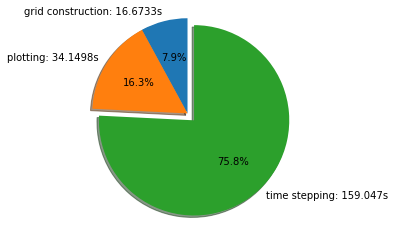

In [33]:
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

We should see that the time spent int the time stepping has gone down. Plotting is slightly faster in most cases, but it depends on your disk speed. This usually is the limiting factor here. The grid construction becomes more expensive as we do quite some load balancing here. To see exactly this load balancing, we exploit the fact that Peano's load balancing toolbox comes along with some scripts of its own that allow us to analyse the decomposition:

In [34]:
import sys
sys.path.append( "../../../src/toolbox/loadbalancing/")
import plot_load_distribution

code does not use MPI
code uses 12 threads per rank
code sets number of threads manually to 12


ValueError: provided too many kwargs, can only pass {'basex', 'subsx', nonposx'} or {'basey', 'subsy', nonposy'}.  You passed {'base': 2}

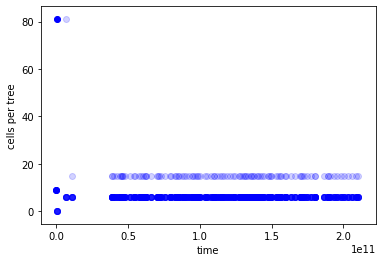

In [35]:
plot_load_distribution.plot( "output-parallel.txt", verbose=False, plot_remote_cells=False, sum_per_rank=False )

code does not use MPI
code uses 12 threads per rank
code sets number of threads manually to 12


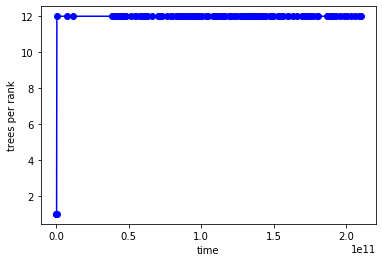

In [36]:
plot_load_distribution.plot_trees_per_rank( "output-parallel.txt", verbose=False )

For most setups, the trees that are deployed to the cores will be ill-balanced. This is a natural consequence of the tree structure. This implies that we cannot exploit the cores effectively with trees only - we have to use tasks, too. For this, we however need another solver:

# Using enclave tasking

Enclave tasking is a technique where a timestep is broken up into two grid traversals, but the first one focuses on the computation along cells that are time-critical. The other operations are spawned as background tasks. A second traversal then gathers the outcomes of these background tasks, i.e. is, more or less, a sole tidy-up sweep. I remove the solvers first and add this new type of enclave solver. I give it the same name as our first solver. The enclave solver is a cousin to the plain one and uses exactly the same signature. We have manually written some flux and eigenvalue functions before. These one thus will then automatically be used here: We specity a solver called Euler, the toolkit will create all solver infrastructure, but it will not overwrite anything called Euler.cpp for or Euler.h as it assumes that you've already written some user-specific code. So this implementation is then used for the enclave solver. As I wrote: Works only as plain and enclave solver have exactly the same signature.

In [37]:
project.remove_all_solvers()
project.add_solver( exahype2.solvers.fv.GenericRusanovFixedTimeStepSizeWithEnclaves(
  "Euler", patch_size, unknowns, auxiliary_variables, min_h, max_h, 0.0001,
  flux=exahype2.solvers.fv.PDETerms.User_Defined_Implementation,
  plot_grid_properties=True
))

In [38]:
peano4_project = project.generate_Peano4_project()
peano4_project.generate( throw_away_data_after_generation=False )


parse configure outcome ../../../src/Makefile to extract compile settings
used C++ compiler is icpc
used Fortran compiler is ifort
generate all code ...
some artefacts have already been added to repository ... assume this is intentional (by higher abstraction layer, e.g.)
generated finitevolumes-main.cpp
write ./Makefile
write ././AbstractEuler.h (generated from template /home/tobias/git/Peano/python/exahype2/solvers/fv/GenericRusanovFixedTimeStepSizeWithEnclavesAbstract.template.h)
write ././AbstractEuler.cpp (generated from template /home/tobias/git/Peano/python/exahype2/solvers/fv/GenericRusanovFixedTimeStepSizeWithEnclavesAbstract.template.cpp)
write ./observers/SolverRepository.h (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.h)
write ./observers/SolverRepository.cpp (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.cpp)
write ./celldata/EulerQ.h (generated from template /home/tobias/g

In [39]:
parallel_builds = 8
peano4_project.build( make_clean_first = True, number_of_parallel_builds = parallel_builds )

clean up project ...
clean complete
start to compile with concurrency level of 8 ...
icpc -std=c++0x -g -O2 -DPeanoDebug=2 -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp  -DDimensions=2 -I. -I../../../src -c -o AbstractEuler.o AbstractEuler.cpp
icpc -std=c++0x -g -O2 -DPeanoDebug=2 -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp -I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include -fopenmp -I/opt/intel/tbb/include -DTBB_U

In [40]:
peano4_project.run( [], prefix = ["mpirun", "-n", "1"], pipefile = "output-enclave.txt", rebuild_if_required=False )

run application ...
 57685616766  00:00:57     rank:0       core:5       warning      tarch::logging::Statistics::writeToCSV(string)          no statistics available. Recompile with -DTrackStatistics for runtime sampling (file:tarch/logging/Statistics.cpp,line:142)

run completed without error code, but check for warnings and numerical assertions/errors


True

We re-evaluate the runtime with the new run. It is only the runtime that will have changed - the switch to another solver will not affect the load balancing (as we work with the same grid). The code however will now use twice as many steps.

In [41]:
import exahype2

performance_data = exahype2.postprocessing.PerformanceData( "output-enclave.txt", verbose=False )

parse output-enclave.txt
h_min=0.111111
grid construction lasts 1.46976 over 7 steps
plotting lasts 2.1831 over 11 steps
time stepping lasts 54.0162 over 202 steps


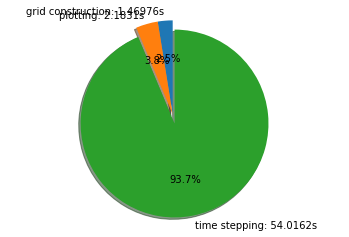

In [42]:
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

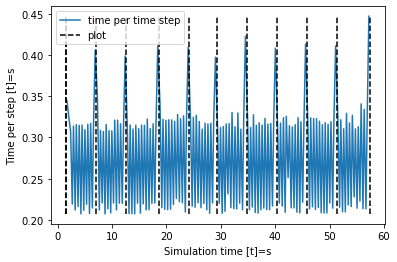

In [43]:
exahype2.postprocessing.plot_time_per_time_step(performance_data)

In [44]:
import peano4.visualisation

convert = peano4.visualisation.Convert( "solution-Euler", True )
convert.set_visualisation_tools_path( "../../../src/convert" )
convert.extract_fine_grid()
convert.convert_to_vtk()

convert = peano4.visualisation.Convert( "grid-Euler", True )
convert.set_visualisation_tools_path( "../../../src/convert" )
convert.extract_fine_grid()
convert.convert_to_vtk()

inspect file solution-Euler ... 
invoke ['../../../src/convert/convert', 'inspect', 'solution-Euler.peano-patch-file']
found selectors {'EulerQ'}
extract fine grid from solution-Euler ... 


KeyboardInterrupt: 

## Troubleshooting

### Ubuntu 

I had issues with matplotlib on Ubuntu (all worked fine on OpenSUSE right from the start). The snippet below resolved that problem. I had to restart the notebook however.

<pre>
import sys  
!{sys.executable} -m pip install --user matplotlib
</pre>

### Python version

If you get errors within Peano or ExaHyPE then you might have spotted a bug there. Before you dive into details, please crosscheck which Python version you run. I require Python 3!

In [ ]:
from platform import python_version

print(python_version())

### Matplotlib generations

In some of my parallel performance analysis scripts, I use the statements

plt.yscale( "log", base=2 )

I think this is a change in the matplotlib signatures, i.e. old codes require you to write basex, while this is deprecated and now should be base. So don't be confused. Maybe update matplotlib.

### Paraview 

If you Paraview display does not work, it might be that you lack the right packages and environment variables. 

On Ubuntu I had to install the package python3-paraview on top of Paraview. 

Furthermore, the PYTHONPATH has to point to the python3.7/site-packages subdirectory. I use for example

export PYTHONPATH=../../../python:/opt/ParaView-5.7.0-MPI-Linux-Python3.7-64bit/lib/python3.7/site-packages
    
before I start the Jupyter lab.